## Import packages

In [1]:
import scipy.io
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.preprocessing import sequence
from pathlib import Path
from matplotlib import pyplot as plt
from keras.utils import to_categorical

Using TensorFlow backend.


## Understand the data
Below are 27 activities. There are 8 subjects (4 males and 4 females) and 4 trials for each recording.
1.  right arm swipe to the left         (swipt_left)
2.  right arm swipe to the right        (swipt_right)
3.  right hand wave                     (wave)
4.  two hand front clap                 (clap) 
5.  right arm throw                     (throw)
6.  cross arms in the chest             (arm_cross)
7.  basketball shooting                 (basketball_shoot)
8.  draw x                              (draw_x)
9.  draw circle  (clockwise)            (draw_circle_CW)
10. draw circle  (counter clockwise)    (draw_circle_CCW)
11. draw triangle                       (draw_triangle)
12. bowling (right hand)                (bowling)
13. front boxing                        (boxing)
14. baseball swing from right           (baseball_swing)
15. tennis forehand swing               (tennis_swing)
16. arm curl (two arms)                 (arm_curl)
17. tennis serve                        (tennis_serve)
18. two hand push                       (push)
19. knock on door                       (knock)
20. hand catch                          (catch)
21. pick up and throw                   (pickup_throw)
22. jogging                             (jog)
23. walking                             (walk)
24. sit to stand                        (sit2stand)
25. stand to sit                        (stand2sit)
26. forward lunge (left foot forward)   (lunge)
27. squat                               (squat)

## Process Depth Data
* Dimension is 240 x 320 x (Number of frames)  
* Convert 320 x 240 pixels to flat array
* Create constant columns for 'action', 'subject', 'trial', 'frame'
* Maximum frames = 125

In [2]:
def import_depth_data(action, subject, trial):
    filename = f'data/Depth/a{action}_s{subject}_t{trial}_depth.mat'
    if Path(filename).is_file():
        mat = scipy.io.loadmat(filename)
        return mat['d_depth']
    else:
        return None

def transform_depth_data(action, subject, trial):
    rows = []
    data = import_depth_data(action, subject, trial)
    if data is None: return None
    for frame in range(data.shape[2]):
        pixels = data[:, :, frame].flatten()
        rows.append(pixels)
    result = np.insert(rows, 0, [[action], [subject], [trial], [frame]], axis=1)
    return np.array(result)

def transform_depth_data_to_df(action, subject, trial):
    data = transform_depth_data(action, subject, trial)
    if data is None: return None
    df = pd.DataFrame(data)
    df.columns = ['action', 'subject', 'trial', 'frame'] + [f'depth_{n}' for n in range(240 * 320)]
    return df

def export_depth_data_to_csv(action, subject, trial):
    df = transform_depth_data_to_df(action, subject, trial)
    if df is None: return None
    filename = f'a{action}_s{subject}_t{trial}_depth.csv'
    df.to_csv(filename, index=False)

def show_depth_image(action, subject, trial, frame):
    data = import_depth_data(action, subject, trial)
    if data is None: return None
    plt.imshow(data[:,:,frame], cmap='gray')
    plt.axis('off')
    plt.show()

## Process Inertial Data
* Dimension is (Number of sample) x 6  
* The 6 columns: acceleration for x, y, z, x-angular, y-angular, z-angular
* Maximum samples = 326

In [3]:
def import_inertial_data(action, subject, trial):
    filename = f'data/Inertial/a{action}_s{subject}_t{trial}_inertial.mat'
    if Path(filename).is_file():
        mat = scipy.io.loadmat(filename)
        return mat['d_iner']
    else:
        return None
    
def transform_inertial_data(action, subject, trial):
    data = import_inertial_data(action, subject, trial)
    if data is None: return None
    result = np.insert(data, 0, [[action], [subject], [trial]], axis=1)
    return np.array(result)

def transform_inertial_data_to_df(action, subject, trial):
    data = transform_inertial_data(action, subject, trial)
    if data is None: return None
    df = pd.DataFrame(data)
    df.columns = ['action', 'subject', 'trial', 'x-accel', 'y-accel', 'z-accel', 'x-ang-accel', 'y-ang-accel', 'z-ang-accel']
    return df

def export_inertial_data_to_csv(action, subject, trial):
    df = transform_inertial_data_to_df(action, subject, trial)
    if df is None: return None
    filename = f'a{action}_s{subject}_t{trial}_inertial.csv'
    df.to_csv(filename, index=False)

## Process Skeleton Data
* Dimension is 20 x 3 x (Number of frame)
* The first dimension is the skeleton joints
* The second dimension is the spatial coordinates (x, y, z)
* Maximum frames = 125 

In [4]:
def import_skeleton_data(action, subject, trial):
    filename = f'data/Skeleton/a{action}_s{subject}_t{trial}_skeleton.mat'
    if Path(filename).is_file():
        mat = scipy.io.loadmat(filename)
        return mat['d_skel']
    else:
        return None

def transform_skeleton_data(action, subject, trial):
    matrices = []
    data = import_skeleton_data(action, subject, trial)
    if data is None: return None
    for frame in range(data.shape[2]):
        skelecton_joints = [i + 1 for i in range(20)]
        matrix = data[:,:,frame]
        matrix = np.insert(matrix, 0, skelecton_joints, axis=1)
        matrix = np.insert(matrix, 0, frame, axis=1)
        matrices.append(matrix)
    result = np.vstack(tuple(matrices))
    result = np.insert(result, 0, [[action], [subject], [trial]], axis=1)
    return result

def transform_skeleton_data_to_df(action, subject, trial):
    data = transform_skeleton_data(action, subject, trial)
    if data is None: return None
    df = pd.DataFrame(data)
    df.columns = ['action', 'subject', 'trial', 'frame', 'skeleton_joint', 'x', 'y', 'z']
    return df

def export_inertial_data_to_csv(action, subject, trial):
    df = transform_skeleton_data_to_df(action, subject, trial)
    if df is None: return None
    filename = f'a{action}_s{subject}_t{trial}_skeleton.csv'
    df.to_csv(filename, index=False)

## Demonstration of sensors data

In [5]:
df = transform_depth_data_to_df(1, 1, 1)
df.head()

,action,subject,trial,frame,depth_0,depth_1,depth_2,depth_3,depth_4,depth_5,...,depth_76790,depth_76791,depth_76792,depth_76793,depth_76794,depth_76795,depth_76796,depth_76797,depth_76798,depth_76799
0,1,1,1,47,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,47,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,47,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,47,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,47,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
df = transform_inertial_data_to_df(1, 1, 1)
df.head()

,action,subject,trial,x-accel,y-accel,z-accel,x-ang-accel,y-ang-accel,z-ang-accel
0,1.0,1.0,1.0,-0.959473,-0.177734,-0.192871,5.221374,1.526718,0.152672
1,1.0,1.0,1.0,-0.961914,-0.153320,-0.159912,6.778626,1.954198,0.244275
2,1.0,1.0,1.0,-0.974609,-0.152832,-0.145996,11.267176,3.175573,1.099237
3,1.0,1.0,1.0,-0.941895,-0.135742,-0.127930,16.885496,4.732824,2.320611
4,1.0,1.0,1.0,-0.958252,-0.201416,-0.139404,16.030534,4.000000,0.366412


In [7]:
df = transform_skeleton_data_to_df(1, 1, 1)
df.head()

,action,subject,trial,frame,skeleton_joint,x,y,z
0,1.0,1.0,1.0,0.0,1.0,-0.045763,0.483985,2.830189
1,1.0,1.0,1.0,0.0,2.0,-0.034567,0.299454,2.877040
2,1.0,1.0,1.0,0.0,3.0,-0.030579,-0.049345,2.890448
3,1.0,1.0,1.0,0.0,4.0,-0.025585,-0.112093,2.839039
4,1.0,1.0,1.0,0.0,5.0,-0.198823,0.187045,2.877829


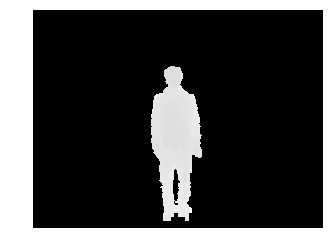

In [8]:
show_depth_image(1, 1, 1, 1)

## Binary Classification using Inertial Data

In [15]:
# Original inertial data has dimension (Number of sample) x 6
# Swap the axes so the new dimension is 6 x (Number of sample)
# Apply padding to each entry, the new dimension is 6 x 326
# Subjects 1, 2, 3, 5, 6, 7 go into training data (75%)
# Subjects 4, 8 go into test data (25%)

X_train = []
Y_train = []
X_test = []
Y_test = []

# Select 3 activites for training:
#     3. right hand wave (wave)
#     18. two hand push (push)
#     22. jogging (jog)
activities = [3, 18, 22]

for index, action in enumerate(activities):
    for subject in range(1, 9):
        for trial in range(1, 5):
            data = import_inertial_data(action, subject, trial)
            if data is None: continue
            data = np.swapaxes(data, 0, 1)
            data = sequence.pad_sequences(data, maxlen=326)
            if subject in [1, 2 ,3, 5, 6, 7] :
                X_train.append(data)
                Y_train.append(index)
            else:
                X_test.append(data)
                Y_test.append(index)
                
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

print('X_train.shape:', X_train.shape)
print('Y_train.shape:', Y_train.shape)
print('X_test.shape:', X_test.shape)
print('Y_test.shape:', Y_test.shape)

X_train.shape: (72, 6, 326)
Y_train.shape: (72,)
X_test.shape: (24, 6, 326)
Y_test.shape: (24,)


In [16]:
# Swap axes again, new dimension is 32 x 326 x 6
# This follows the standard of LSTM: Samples, Timesteps, Dimensions
X_train = np.swapaxes(X_train, 1, 2)
X_test = np.swapaxes(X_test, 1, 2)

print('X_train.shape:', X_train.shape)
print('Y_train.shape:', Y_train.shape)
print('X_test.shape:', X_test.shape)
print('Y_test.shape:', Y_test.shape)

X_train.shape: (72, 326, 6)
Y_train.shape: (72,)
X_test.shape: (24, 326, 6)
Y_test.shape: (24,)


In [17]:
# One hot encoding
Y_train = to_categorical(Y_train, num_classes=len(activities))
Y_test = to_categorical(Y_test, num_classes=len(activities))

print('X_train.shape:', X_train.shape)
print('Y_train.shape:', Y_train.shape)
print('X_test.shape:', X_test.shape)
print('Y_test.shape:', Y_test.shape)

X_train.shape: (72, 326, 6)
Y_train.shape: (72, 3)
X_test.shape: (24, 326, 6)
Y_test.shape: (24, 3)


In [18]:
# Create the model
np.random.seed(7)
model = Sequential()
model.add(LSTM(128, input_shape=(326, 6)))
model.add(Dense(len(activities), activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
print(model.summary())
model.fit(X_train, Y_train, epochs=100)

scores = model.evaluate(X_test, Y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128)               69120     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 387       
Total params: 69,507
Trainable params: 69,507
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
72/72 [==============================] - 1s - loss: 1.1861 - acc: 0.3056     
Epoch 2/100
72/72 [==============================] - 1s - loss: 1.1485 - acc: 0.3750     
Epoch 3/100
72/72 [==============================] - 1s - loss: 1.1236 - acc: 0.4028     
Epoch 4/100
72/72 [==============================] - 1s - loss: 1.1109 - acc: 0.4167     
Epoch 5/100
72/72 [==============================] - 1s - loss: 1.0926 - acc: 0.4306     
Epoch 6/100
72/72 [==============================] - 1s - loss: 1.0743 - acc: 0

72/72 [==============================] - 1s - loss: 0.6606 - acc: 0.7917     
Epoch 85/100
72/72 [==============================] - 1s - loss: 0.6670 - acc: 0.8056     
Epoch 86/100
72/72 [==============================] - 1s - loss: 0.6623 - acc: 0.8194     
Epoch 87/100
72/72 [==============================] - 1s - loss: 0.6537 - acc: 0.8056     
Epoch 88/100
72/72 [==============================] - 1s - loss: 0.6596 - acc: 0.7917     
Epoch 89/100
72/72 [==============================] - 1s - loss: 0.6411 - acc: 0.8194     
Epoch 90/100
72/72 [==============================] - 1s - loss: 0.6344 - acc: 0.8056     
Epoch 91/100
72/72 [==============================] - 1s - loss: 0.6344 - acc: 0.8333     
Epoch 92/100
72/72 [==============================] - 1s - loss: 0.6317 - acc: 0.8056     
Epoch 93/100
72/72 [==============================] - 1s - loss: 0.6246 - acc: 0.8056     
Epoch 94/100
72/72 [==============================] - 1s - loss: 0.6288 - acc: 0.8056     
Epoch 95/100